# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :**

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation.

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [11]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device type:", device.type)

Device type: cuda


In [3]:
# Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 10

# Check Download
download = True

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=download, transform=transform)
nolabelset = torch.utils.data.Subset(trainset, list(range(100, len(trainset))))
trainset = torch.utils.data.Subset(trainset, list(range(100)))

# Set num_workers to accelerate data loading
nolabel_dataloader = torch.utils.data.DataLoader(nolabelset, batch_size=batch_size, shuffle=True, num_workers=4)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=download, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


100%|██████████| 170498071/170498071 [00:12<00:00, 13134109.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [4]:
print("Train Dataloader Length:", len(train_dataloader), "No Label Dataloader Length:", len(nolabel_dataloader), "Test Dataloader Length:", len(test_dataloader))


Train Dataloader Length: 10 No Label Dataloader Length: 4990 Test Dataloader Length: 1000


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project.

* The remaining samples correspond to $\mathcal{X}$.

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

It is difficult since there is a risk of overfitting the training data after a few epochs. In particular, this risk is especially high in this case, as we only have 100 training samples available.

Solution 1:Evaluate the training procedure involves incorporating a validation set into the training process, which allows us to assess the loss and accuracy of the model on data that is separate from the training set at each epoch, helping us identify when the model starts to overfit.

Solution 2: Use a portion of the unlabeled data.Employ an unsupervised learning technique, such as clustering, on a combination of the training data and a subset of the unlabeled data to infer labels for the unlabeled samples. Then, during the training process on the labeled data, we could compare the model's predictions with these inferred labels to assess their alignment.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf.

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [6]:
model = ResNet18()
model.to(device)

epochs = 50
batch_size = 10
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_update_period = 30
milestones = list(range(0, epochs, lr_update_period))[1:]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

Epochs: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]
<ipython-input-7-f152b2c9a5ac>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


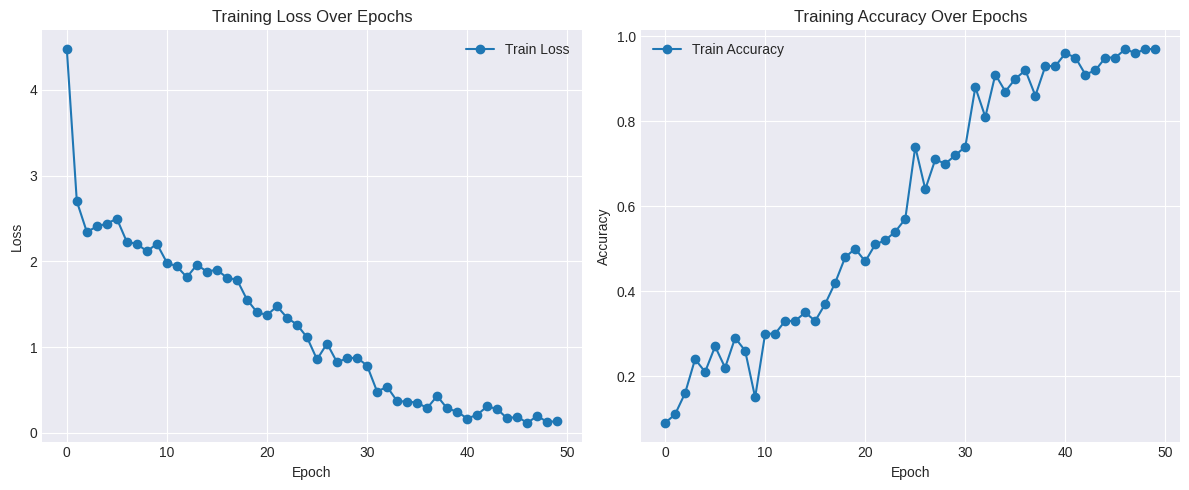

Final Train Loss: 0.1361
Final Train Accuracy: 0.9700


In [7]:
def train(model, train_dataloader, criterion, optimizer, scheduler, epochs, device):
    model.to(device)
    total_train_losses = []
    total_train_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = correct_predictions / total_predictions
        total_train_losses.append(epoch_loss)
        total_train_accuracies.append(epoch_accuracy)

        scheduler.step()

    # Plot loss and accuracy
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(total_train_losses, marker='o', label='Train Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(total_train_accuracies, marker='o', label='Train Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final training results
    print(f'Final Train Loss: {total_train_losses[-1]:.4f}')
    print(f'Final Train Accuracy: {total_train_accuracies[-1]:.4f}')

train(model, train_dataloader, criterion, optimizer, scheduler, epochs, device)

In [8]:
def test(model, test_dataloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total  # loss
    test_accuracy = correct / total  # accuracy

    print(f'Final Test Loss: {test_loss:.4f}')
    print(f'Final Test Accuracy: {100 * test_accuracy:.2f}%')

test(model, test_dataloader, criterion, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Test Loss: 0.4039
Final Test Accuracy: 21.48%


### Results

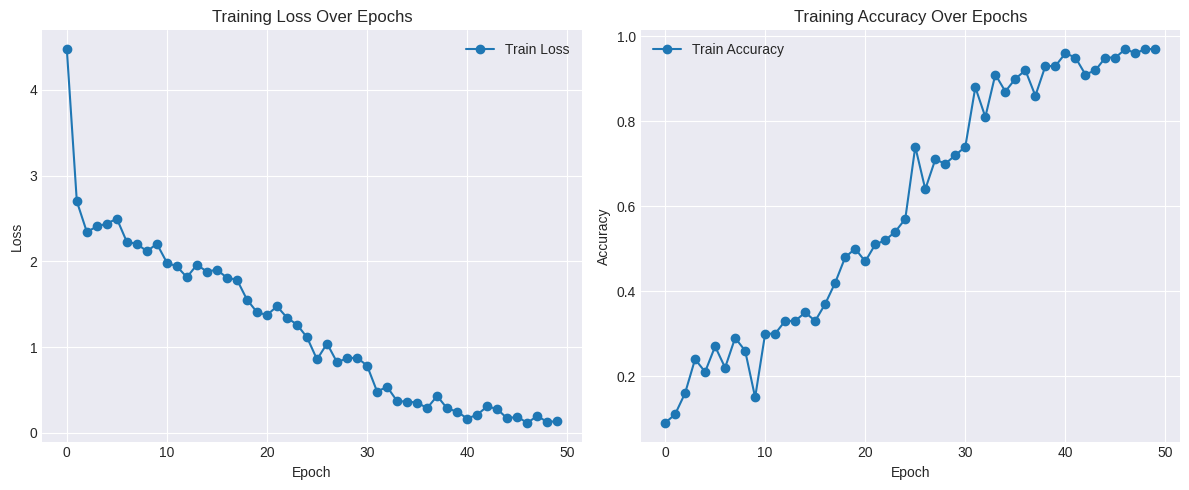<center>

| Model      | Number of epochs | Train accuracy | Test accuracy |
|------------|------------------|----------------|---------------|
| ResNet18   | 50               | 0.9700         | 21.48%        |

</center>


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

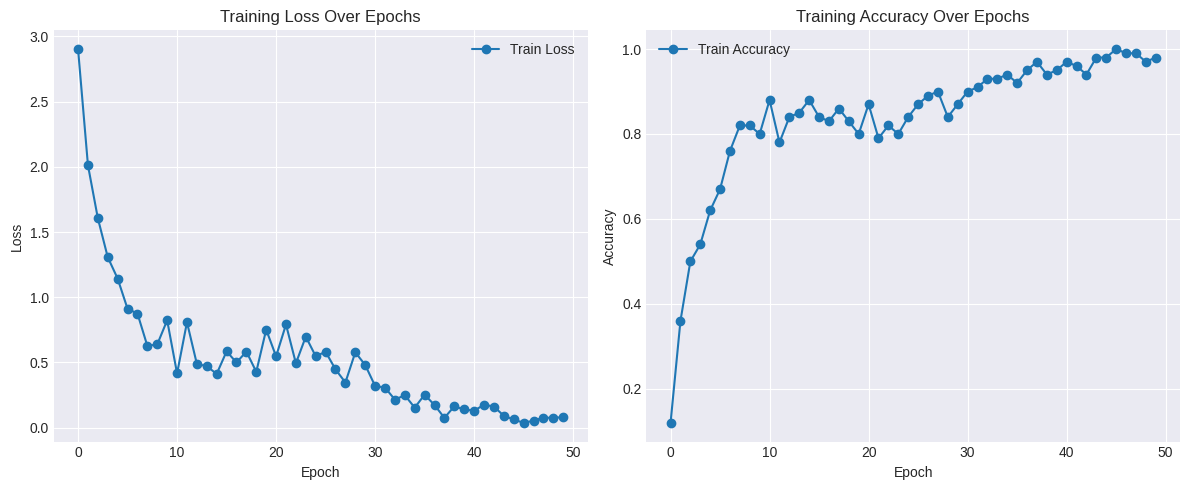

Final Train Loss: 0.0799
Final Train Accuracy: 0.9800


In [14]:
#Modify ResNet18 for CIFAR
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


epochs = 50
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_update_period = 30
milestones = list(range(0, epochs, lr_update_period))[1:]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

train(model, train_dataloader, criterion, optimizer, scheduler, epochs, device)

In [16]:
test(model, test_dataloader, criterion, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Test Loss: 0.2471
Final Test Accuracy: 30.05%


### Results

<center>

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 50 | 0.9700 | 21.48% |
|   ResNet18 (transfer learning)  | 50 | 0.9800 | 30.05% |

</center>

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

When we mess around with 32*32 images by shifting them, rotating them, scaling them, or changing their colors, we end up losing some details. And since these small images don't have much detail to begin with, these changes can make them too distorted. This means the features that the model needs to learn from might not be clear anymore.

To avoid this, we could stick to making only small adjustments like tiny shifts or rotations. This way, most of the important stuff in the image stays intact. Another option is to make the images bigger using special methods that fill in the gaps caused by resizing, which can help preserve more of the original information.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [18]:
#Transformation Beyond Translation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset = torch.utils.data.Subset(trainset, list(range(100)))
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [22]:
model = ResNet18()
model.to(device)

epochs = 50
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_update_period = 30
milestones = list(range(0, epochs, lr_update_period))[1:]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

Epochs: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]
<ipython-input-7-f152b2c9a5ac>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


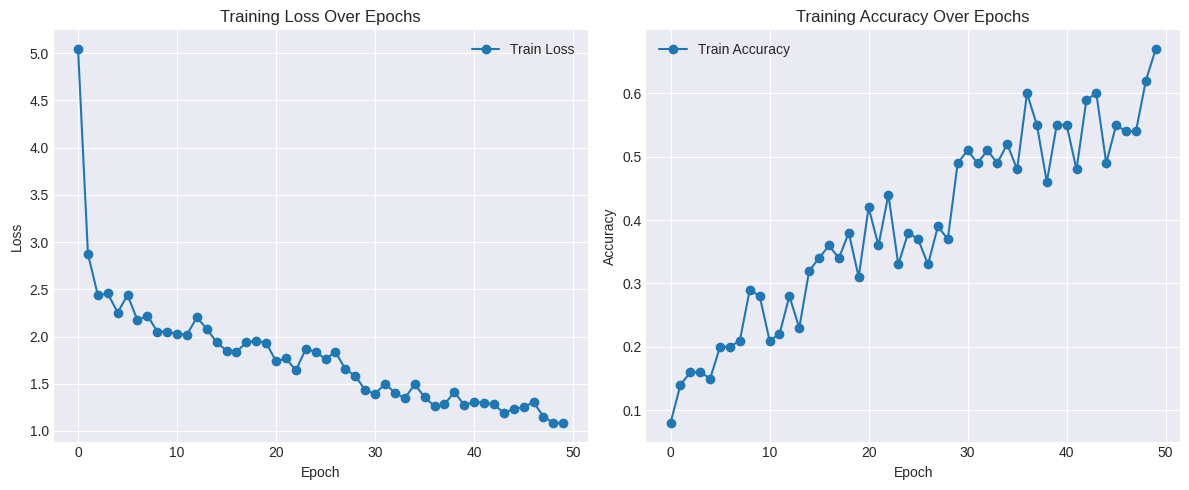

Final Train Loss: 1.0854
Final Train Accuracy: 0.6700


In [23]:
train(model, train_dataloader, criterion, optimizer, scheduler, epochs, device)

In [24]:
test(model, test_dataloader, criterion, device)

Final Test Loss: 0.2824
Final Test Accuracy: 22.97%


### Results

<center>

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 50 | 0.9700 | 21.48% |
|   ResNet18 (transfer learning)  | 50 | 0.9800 | 30.05% |
|   ResNet18 (data augmentation)  | 50 | 0.6700 | 22.97% |


<center>

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

----


In this notebook, we applied three training approaches to the CIFAR-10 dataset, using a minimal training set of only 100 samples, while the testing set consisted of 10,000 samples. The table below shows the accuracies achieved by each method.

### Results

<center>

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 50 | 0.9700 | 21.48% |
|   ResNet18 (transfer learning)  | 50 | 0.9800 | 30.05% |
|   ResNet18 (data augmentation)  | 50 | 0.6700 | 22.97% |


<center>

## Method 1: ResNet18 Trained from Scratch

### Advantages
- The model is not constrained by pre-trained weights, allowing unique architecture choices.

### Drawbacks
- Prone to overfitting, especially with limited training data.
In our experiment, we observed that the final test loss, which amounted to 0.4039, was approximately four times higher than the final train loss, which was 0.1361.

- Takes longer to converge to a higher accuracy.From the first accuracy graph,we could observe that this method takes a longer time to a good accuracy compared to the other two

## Method 2: ResNet18 with Transfer Learning

### Advantages
- Achieves high training accuracy quickly, with over 80% after just 20 epochs.As shown in the accuracy graph bellow, the model reaches a training accuracy over 80% after only 10 epochs and at the 40th epoch it reached 100% accuracy already

- Reaches a lower training loss due to pre-learned feature representations.The training loss ended up at 5 times lower than with the previous method.

### Drawbacks
- Still risks overfitting as indicated by the disparity between training and testing results.We can see it in the clear gap in training and testing accuracies but also in the fact that the model reaches 100% training accuracy after 40 epochs. We need to carefully fine tune the learning rate and number of epochs in order to reduce this risk.

- Model architecture is limited to those pre-trained on ImageNet.Many pre-trained models are available but it does not allow for unlimited freedom in the architecture of the model.

## Method 3: ResNet18 with Data Augmentation

### Advantages

-An interesting observation here is that despite its relatively lower accuracy on the training set compared to other methods, its performance on the test set is only inferior to the third method and shows an improvement over the first method. This suggests a reduction in overfitting to some extent.

- Enhances learning on small datasets by creating additional training samples.
- Flexible in model architecture, not limited by pre-trained weights.

### Drawbacks
- Limited transformations due to small image size, reducing the method's effectiveness.
- Though improved,Overfitting is still a concern; data augmentation did not significantly improve testing results.

## Conclusion

While transfer learning showed promising training accuracy, it also indicated a risk of overfitting. Training from scratch, with and without data augmentation, showed that augmentation could potentially improve model generalization but still did not prevent overfitting since the limitation of the size.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.